# Showing A Few Results From R Code in Project

If you want more details on any variable, dataset, or script file (.R extension), see the GitHub's README and  ```Master-NBA.R```, which is quite detailed in explaining every file, and then you can go into each file to see everything I've run. Below is just summarizing **a few** of the many fun things that are contained within the many scripts and datasets created. Keep in mind the ```Housekeeping.R``` file if you want to run anything locally that is not contained in this notebook. 

**Section 1** creates a high-dimensional player projection model, that performs quite well out of sample and does a good job of identifying the best consensus NBA players. 

**Section 2** creates a game projection model that is quite predictive of how many points the home team should be favored by, and is good at estimating the % chance the home team has of winning, based on many carefully constructed variables. It then uses said model to rank the teams at the end of the 2022-23 season against each other. 

**Section 3** shows that the linear model I have performs quite well against gambling markets. 

**Section 4** is a fun little problem of trying to estimate what the distribution of game outcomes (distribution over expected point differential of the home team at the end of the game) should look like, and how that should vary depending on how big a favorite the home team is. It uses a clever application of a maximum likelhood estimation to construct this theoretical distribution, even where empirical data is limited.

**Section 5** implements a neural network from scratch (i.e. constructs the matrices for each step of the process, as well as the gradients) and compares a simple neural network model to logistic regression for predicting how likely the home team is to win.

In [1]:
#0. Clean up and erase

rm(list=ls())

#ONLY INTPUT IS WORKING DIRECTORY OF GITHUB REPO
#setwd("/Users/To/GitHub/NBADataProject/R/")
setwd("/Users/ricardovelloso/git-projects/NBADataProject/R/")
#1. Load Relevant Packages and Set WD

library('tidyverse')
library('lubridate')
library('ggplot2')
library('stringr')
library('stringi')
library('selectr')
library('ds4psy')
library('dplyr')
library("xlsx")
library(parallel)
library(extrafont)
library(ggrepel)
library(tidyverse)
library(scales)
library("httr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Welcome to ds4psy (v0.8.0)!


Attaching package: ‘ds4psy’


The following object is masked from ‘package:lubridate’:

    days_in_month


Registering fonts with R


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## 1. Using Ridge Regression to Create High-Dimensional Player Rating Calculator
I have compiled quite an exhaustive list of player data. I have literally every play of every NBA game of the past 25 years, and exactly who was playing from both teams on all plays. I also have how many points, rebounds, assists, blocks, steals and shots each player had in each game, among many other statistics.

Other than all the cleaning and variable creation (which again reference the "Master-NBA" file for more detail, most of the player-based forecasting model can be seen in ```OnOff_AdjPM.R``` and ```ComputeBestPlayers.R```. The first calculates each player's contribution in terms of how many more points they added of success to their team when they player. Imagine a set of thousands of dummies, each representing each player in the NBA over the past 5 years. It turns on "1" when the player is on the court and 0 otherwise. At any given time only 5 players on each team (10 total) can be on the court for any given play in any given game. That way, we can get an estimate of the coefficient on each dummy, which is in essence how much better the Player X's team was when Player X was on the court, CONTROLLING FOR the quality of the other 9 players.

If the coefficient is +5, that means the player adds 5 points per game to their team relative to a replacement player (which is very good) and minus numbers are bad. The model is quite a bit more complicated (again look to the code for details), and serves as a more complicated version of the "Regularized Adjusted Plus-Minus" (RAPM) models many NBA analysts use to deterine how good players are.

On top of that, I include many other player variables (aggregated over the past 5 years in a way to more weight on more recent seasons), and combine all those variables into a regression model that uses the dummy coefficients and all other statistics to try to predict how good a player will be over the next 12 months (I use a players future 1-year RAPM as what I am trying to predict). I also incorporate things like age, experience, and position. 

In that sense, at any given moment in time, I use many variables (and combinations of those variables) from the past 5 years to try to predict how good players will be over the next year. The model is decently more complex than most of the "advanced analytics" NBA player ratings you see, and is not bound by just looking at a player's CURRENT season performance (which most do). Below I run a subset of the code to produce a chart.

In [2]:
defaultW <- getOption("warn") 
options(warn = -1)
source("PlayerModel.R")

Joining, by = c("PlayerID", "Date")
Joining, by = "PlayersFull"
Joining, by = c("PlayerID", "Date")
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
Joining, by = c("PlayerID", "RAPM5_total", "RAPM5_off", "RAPM5_def")
Joining, by = "PlayerID"


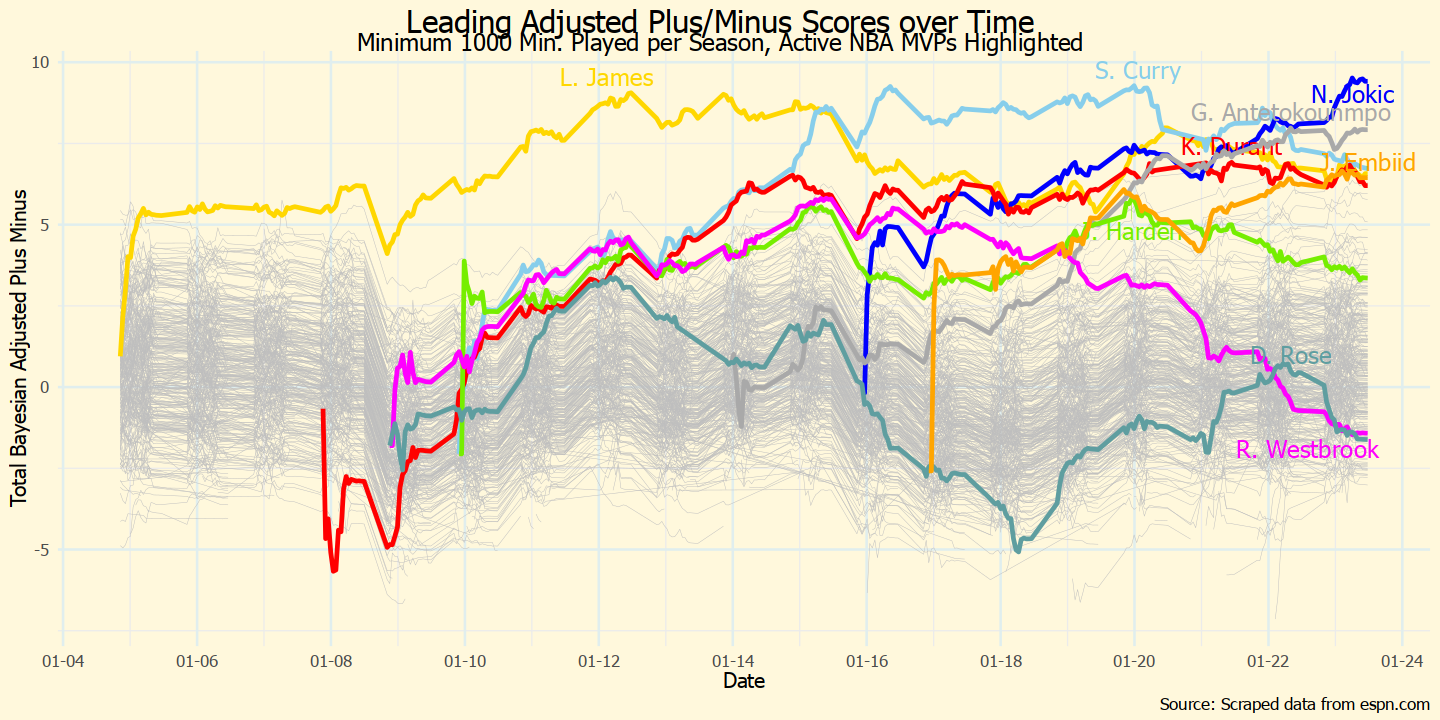

In [3]:
#graph chart
options(repr.plot.width = 12, repr.plot.height = 6)
chart

You can see a list of player ratings over time. Remember the "replacement player" can be worse or better over time, which is why the chart shifts a bit up and down, but mostly the average (the highest-density area) hovers around 0. 

You can see some interesting trends for the past 9 MVPs! LeBron James was the dominant player (according to my metric at least) from 2009-2015, far and away from second place. Similary, Stephen Curry had a long stretch on top until getting injured in 2020. For the past few years there have been a lot of players at or near that +7-+8 rating (Kevin Durant, Giannis Antetokounmpo, Joel Embiid), but in the past year or so Nokola Jokic has started to distance himself a bit, and is currently atop.

I list the top 20 players below for the end of the 2022-23 season. This suggests that Nikola Jokic is expected to be worth +9.41 points per game more than a "replacement-level" player. This seems a bit high to me, but replacement levels rate worse now than they used to in the mid-2000s because teams play many more players (meaning fewer minutes are played by the best players relative to past years). So in a sense his rating is not an apples-to-apples comparison with previous years. You can see that upward drift showing up a bit in the chart. And the rating may not be too high: this year the Nuggets were +24 points better with Jokic in the game than when he was out of the game.

In [4]:
currentranksTOT[1:20,c("PlayersFull","VellosoPlusMinus_total","Rank_tot")]

PlayersFull,VellosoPlusMinus_total,Rank_tot
<chr>,<dbl>,<int>
Nikola Jokic,9.413295,1
Giannis Antetokounmpo,7.924058,2
Kawhi Leonard,7.618986,3
Stephen Curry,6.730524,4
LeBron James,6.571064,5
Joel Embiid,6.447220,6
Jayson Tatum,6.291554,7
Kevin Durant,6.201478,8
Kyrie Irving,5.952147,9


## 2. Using a Predictive Model To Compare How Teams Would Perform Against Each Other

First, load a dataset that has for ~25000 NBA games since 2003 with a lot of carefully constructed variables that should be predictive of team performance, including past performance, player quality, home court advantage, etc.

If you want more details for how each variable was constructed, see ```Master-NBA.R```. 
This explains all cleaning and all the created variables, and you can see each script being referred to in more detail in the "R" folder.

In [5]:
#get data from public dropbox link with my data
fileLinks <- c("allregdata_FINALV2.RData",
               "combdata.RData",
               "combdataplayoffs.RData")
for (i in fileLinks) {
  link <- paste0("https://www.dropbox.com/scl/fo/51g9vud1seqtjmyl2gdxt/h/",i,"?rlkey=w73ql5hcbve241kau127t2a2h&dl=1",sep="")
  download.file(link,i)
  load(i)
}

Creating today's date and some last-minute removal of data rows with no team name

In [6]:
ifelse(as.numeric(substr(Sys.time(),12,13))>=20&as.numeric(substr(Sys.time(),12,13))<24,today <- (today()+1),today <- today())
startdate <- today
seasondata <- seasondata[seasondata$Team.x!="TBD "&seasondata$Team.y!="TBD ",]
seasondata <- seasondata[seasondata$Team.x!="TBD"&seasondata$Team.y!="TBD",]
preddata_final <- seasondata[seasondata$Date>=today,]
seasondata <- seasondata[seasondata$Date<(today),]

[1] 19570


Below is the code for two regression models. ```predictline``` predicts the expected margin for the game for the home team, and ```predictwin``` predicts whether the home team will win.

A lot of feature selection processes went into this, in short it was a stepwise feature selection by picking the most important features, and then using some of my own basketball intution for variables I know are likely to be important. Finally, I did out-of-sample testing for a variety of models and the ones below were the best performance.

Key features/variables in the dataset are explained below (you can always refer to the master-NBA file for more detail on any variable): 

(1) "NetAdj..." variables take each team's average margin against opponents, adjusted by quality of opposition. I do it for the whole season, and for the most recent 5, 10 and 20 games to capture recent momentum. It is a bit more complicated. I use an empirical bayes approach at the beginning of the season, because the first few games of the season there is no "prior" data and you do not want to take the average margin of just one or two games. Rather, I construct a prior based on last season and roster changes, to gradually adjusted the posterior mean as the season matures. This smooths te adjusted net margin until game 20, which then only inputs the current season's data.; 

(2)".x" is for the home team and ".y" indicates away team. 

(3) "BtoB" indicates they played a game yesterday (and are hust tired); 

(4) There are various other variable related to how strong each team's home court advantage is, distance traveled to games, whether it is the Playoffs (when home court is bigger); 

(5) Any "TeamQual" variables use my own player ratings to construct the weighted average quality of the team (by number of minutes played). A team may have performed poorly recently because their best player was out, and is now back in the lineup, and you want to adjust for this.

It does quite a good job! It outperforms gambling lines (shown later) and non-linear methods, given the 25000 sample is not enough to leverage these tools and my prior knowledge of what may matter helps here.

In [7]:
predictline <- lm(formula = HomeMargin ~ NetAdjMarg3.x + NetAdjMarg3.y +
                                    + RegularSeason + Playoffs +
                    BtoB.x + BtoB.y + Bubble + Pandemic + PartialPandemic
                  + Pace2.x + Pace2.y 
                  + grthomecourt.x + prgdhomecourt.x + prbadhomecourt.x + rlybadhomecourt.x + avg2homecourt.x
                  + grtawaycourt.y + prgdawaycourt.y + prbadawaycourt.y + rlybadawaycourt.y + avg2awaycourt.y 
                  + PaceXSq2 + PaceYSq2 + PaceXPace2  + GameDummyLess20
                  + AdjNetMarSqPlusv3 + AdjNetMarSqNegv3 + Year + YearSq + WinPct2.x + WinPct2.y
                  + NetAdjMarg320.x + NetAdjMarg320.y + NetAdjMarg310.x + NetAdjMarg310.y
                  + NetAdjMarg35.x + NetAdjMarg35.y + WinPctX20.x + WinPctX20.y
                  + DistDummy2 + DistDummy3 + DistDummy4 + DistDummy5
                  + DistDummy6 + DistDummy7 + OnOffAdjustment.x
                  + Box1Adjustmentv2.x + Box1Adjustmentv2sq.x 
                  + OnOffAdjustment.y
                  + Box1Adjustmentv2.y + Box1Adjustmentv2sq.y 
                  + HomeAdj20.x + HomeAdj10.x + HomeAdj5.x
                  + HomeAdj20.y + HomeAdj10.y + HomeAdj5.y + HomeAdjAll.x + HomeAdjAll.y 
                  + TeamQualORPM.x + TeamQualDRPM.x + TeamQualORPMsq.x + TeamQualDRPMsq.x +
                    TeamQualORPM.y + TeamQualDRPM.y + TeamQualORPMsq.y + TeamQualDRPMsq.y +
                    TeamQualORPM.x*GameDummyLess20 + TeamQualDRPM.x*GameDummyLess20 +
                    TeamQualORPM.y*GameDummyLess20 + TeamQualDRPM.y*GameDummyLess20 +
                    HomeTeamSeriesAdv + AwayTeamSeriesAdv + TwoThree + ThreeZeroComb + DownTwo
                  + Tankathon.x + Tankathon.y + PlayoffExpMin.x + PlayoffExpMin.y
                  + PlayoffExpMin.x*RegularSeason + PlayoffExpMin.y*RegularSeason + NumGamesWeek.x
                  + NumHomeGamesWeek.x + NumGamesWeek.y + NumHomeGamesWeek.y 
                  + TotalFoulsAvg + RefTOSumAvg + TotalFoulsAvg10 + RefTOSumAvg10 + 
                  OneZeroComb, data = seasondata[seasondata$Season>="2007-08",])

predictwin <- glm(formula = HomeWin ~ NetAdjMarg11.x + NetAdjMarg11.y +
                     + RegularSeason + Playoffs +
                     BtoB.x + BtoB.y + Bubble + Pandemic + PartialPandemic
                   + Pace2.x + Pace2.y                     
                   + grthomecourt.x + prgdhomecourt.x + prbadhomecourt.x + rlybadhomecourt.x + avg2homecourt.x
                   + grtawaycourt.y + prgdawaycourt.y + prbadawaycourt.y + rlybadawaycourt.y + avg2awaycourt.y 
                   + PaceXSq2 + PaceYSq2 + PaceXPace2  + GameDummyLess20 +
                   + AdjNetMarSqPlusv11 + AdjNetMarSqNegv11 + Year + YearSq + WinPct2.x + WinPct2.y
                   + NetAdjMarg1120.x + NetAdjMarg1120.y 
                   + NetAdjMarg1110.x + NetAdjMarg1110.y
                   + NetAdjMarg115.x + NetAdjMarg115.y  + WinPctX20.x + WinPctX20.y
                   + DistDummy2 + DistDummy3 + DistDummy4 + DistDummy5
                   + DistDummy6 + DistDummy7 + OnOffAdjustment.x
                   + Box1Adjustmentv2.x + Box1Adjustmentv2sq.x 
                   + OnOffAdjustment.y
                   + Box1Adjustmentv2.y + Box1Adjustmentv2sq.y 
                   + HomeAdj20.x 
                   + HomeAdj10.x + HomeAdj5.x
                   + HomeAdj20.y 
                   + HomeAdj10.y + HomeAdj5.y + HomeAdjAll.x + HomeAdjAll.y + OppWinPct.x
                   + OppWinPct.y 
                   + TeamQualORPM.x + TeamQualDRPM.x + TeamQualORPMsq.x + TeamQualDRPMsq.x +
                     TeamQualORPM.y + TeamQualDRPM.y + TeamQualORPMsq.y + TeamQualDRPMsq.y +
                     TeamQualORPM.x*GameDummyLess20 + TeamQualDRPM.x*GameDummyLess20 +
                     TeamQualORPM.y*GameDummyLess20 + TeamQualDRPM.y*GameDummyLess20 +
                     HomeTeamSeriesAdv + AwayTeamSeriesAdv + TwoThree + ThreeZeroComb + DownTwo
                   + Tankathon.x + Tankathon.y + PlayoffExpMin.x + PlayoffExpMin.y
                   + PlayoffExpMin.x*RegularSeason + PlayoffExpMin.y*RegularSeason + NumGamesWeek.x
                   + NumHomeGamesWeek.x + NumGamesWeek.y + NumHomeGamesWeek.y 
                   + TotalFoulsAvg + TotalFoulsAvg*RegularSeason + 
                   OneZeroComb, data = seasondata[seasondata$Season>="2007-08",], family = binomial(link = "logit"))

In [8]:
summary(predictline)


Call:
lm(formula = HomeMargin ~ NetAdjMarg3.x + NetAdjMarg3.y + +RegularSeason + 
    Playoffs + BtoB.x + BtoB.y + Bubble + Pandemic + PartialPandemic + 
    Pace2.x + Pace2.y + grthomecourt.x + prgdhomecourt.x + prbadhomecourt.x + 
    rlybadhomecourt.x + avg2homecourt.x + grtawaycourt.y + prgdawaycourt.y + 
    prbadawaycourt.y + rlybadawaycourt.y + avg2awaycourt.y + 
    PaceXSq2 + PaceYSq2 + PaceXPace2 + GameDummyLess20 + AdjNetMarSqPlusv3 + 
    AdjNetMarSqNegv3 + Year + YearSq + WinPct2.x + WinPct2.y + 
    NetAdjMarg320.x + NetAdjMarg320.y + NetAdjMarg310.x + NetAdjMarg310.y + 
    NetAdjMarg35.x + NetAdjMarg35.y + WinPctX20.x + WinPctX20.y + 
    DistDummy2 + DistDummy3 + DistDummy4 + DistDummy5 + DistDummy6 + 
    DistDummy7 + OnOffAdjustment.x + Box1Adjustmentv2.x + Box1Adjustmentv2sq.x + 
    OnOffAdjustment.y + Box1Adjustmentv2.y + Box1Adjustmentv2sq.y + 
    HomeAdj20.x + HomeAdj10.x + HomeAdj5.x + HomeAdj20.y + HomeAdj10.y + 
    HomeAdj5.y + HomeAdjAll.x + HomeAdjAll.y 

#### Using Predicted Margin to Create Power Rankings at end of 2022-23 Season
One thing we can do with the ```predictline``` model is take every team's data at the end of the season (i.e fix the roster and all other variables to the end of the season) and then predict how they would perform against an "average" team which is exactly average across all variables. That is, simulate an average team, have each team "play" this team once home and once away, and calculate the expected margin.

I gathered this data already in ```combdata.RData``` and ```combdataplayoffs.RData```, and let the models do the rest below. Finally, I print a table that ranks each team from best to worst using my regression model

In [9]:
defaultW <- getOption("warn") 
options(warn = -1) 
test <- combdata[1:30,c("Team.y","NetAdjMarg3.y","TeamQualORPM.y","TeamQualDRPM.y")]
test$TeamQualRPM <- test$TeamQualORPM.y + test$TeamQualDRPM.y
test <- dplyr::rename(test,TeamQualORPM=TeamQualORPM.y,TeamQualDRPM=TeamQualDRPM.y,NetAdjMarg3=NetAdjMarg3.y,Team=Team.y)
powerrankings <- data.frame(combdata$Team.x,combdata$Team.y,predict(predictline,combdata),predict(predictline,combdataplayoffs))
powerrankings$Team <- ifelse(powerrankings$combdata.Team.y=="Atlanta Hawks",powerrankings$combdata.Team.x,powerrankings$combdata.Team.y)
powerrankings$predict.predictline..combdata. <- ifelse(powerrankings$combdata.Team.y=="Atlanta Hawks",powerrankings$predict.predictline..combdata.,-1*powerrankings$predict.predictline..combdata.)
powerrankings$predict.predictline..combdata.[powerrankings$combdata.Team.x=="Atlanta Hawks"&powerrankings$combdata.Team.y=="Atlanta Hawks"] <- c(-1,1)*powerrankings$predict.predictline..combdata.[powerrankings$combdata.Team.x=="Atlanta Hawks"&powerrankings$combdata.Team.y=="Atlanta Hawks"]
powerrankings$predict.predictline..combdataplayoffs. <- ifelse(powerrankings$combdata.Team.y=="Atlanta Hawks",powerrankings$predict.predictline..combdataplayoffs.,-1*powerrankings$predict.predictline..combdataplayoffs.)
powerrankings$predict.predictline..combdataplayoffs.[powerrankings$combdata.Team.x=="Atlanta Hawks"&powerrankings$combdata.Team.y=="Atlanta Hawks"] <- c(-1,1)*powerrankings$predict.predictline..combdataplayoffs.[powerrankings$combdata.Team.x=="Atlanta Hawks"&powerrankings$combdata.Team.y=="Atlanta Hawks"]
powerrankings <- powerrankings %>%
  dplyr::group_by(Team) %>%
  dplyr::summarize(Rating = mean(predict.predictline..combdata.),
                   PlayoffRating = mean(predict.predictline..combdataplayoffs.))
powerrankings$Rating <- powerrankings$Rating-mean(powerrankings$Rating)
powerrankings$PlayoffRating <- powerrankings$PlayoffRating-mean(powerrankings$PlayoffRating)
powerrankings <- powerrankings %>% left_join(test,by=c('Team')) %>% ungroup()
powerrankings$TeamQualDRPM <- powerrankings$TeamQualDRPM-mean(powerrankings$TeamQualDRPM)
powerrankings$TeamQualORPM <- powerrankings$TeamQualORPM-mean(powerrankings$TeamQualORPM)
powerrankings$TeamQualRPM <- powerrankings$TeamQualRPM-mean(powerrankings$TeamQualRPM)
powerrankings[,c("Rating","NetAdjMarg3","TeamQualRPM")] <- round(powerrankings[,c("Rating","NetAdjMarg3","TeamQualRPM")],digits=1)
powerrankings <- powerrankings[,c("Team","Rating","NetAdjMarg3","TeamQualRPM")]
powerrankings <- rename(powerrankings,ActualAdjMargin=NetAdjMarg3,PlayerQuality=TeamQualRPM)
powerrankings <- powerrankings[order(-powerrankings$Rating),]
print(powerrankings,n=30)
options(warn = defaultW)

# A tibble: 30 × 4
   Team                   Rating ActualAdjMargin PlayerQuality
   <chr>                   <dbl>           <dbl>         <dbl>
 1 Denver Nuggets            7.8             4            10.9
 2 Boston Celtics            6.2             5.9           8  
 3 Milwaukee Bucks           4.5             2.9           7.9
 4 Toronto Raptors           3.9             1.3           6.5
 5 Los Angeles Lakers        3.8             1.1           5.3
 6 Golden State Warriors     3.7             1.5           7.1
 7 Philadelphia 76ers        3.5             4             5  
 8 Cleveland Cavaliers       3.2             4.6           3.4
 9 Memphis Grizzlies         2.5             2.8           1.9
10 Dallas Mavericks          2.3            -0.3           2.4
11 Miami Heat                2.3             1             2.4
12 New York Knicks           2               2.8          -0.4
13 Phoenix Suns              2               1.8           1.7
14 New Orleans Pelicans      1.1    

It is sorted by the first, which is from my model prediction. The second and third columns look at actual net margin for each team during the season and the weighted-average player quality by my player quality indicator.

The model seems to hold up! The NBA champion Denver Nuggets "rate" as the best. They would be expected to beat an average team by 7.8 points, and the second place Boston Celtics by 1.6 points. 

And it is not just taking past performance: the Nuggets were only 4th in Adjusted Margin (i.e. actual net margin over the year), but were upgraded in the model because their roster was very good (Player Quality) and was healthy in the end (Jokic ranks as the best player by my metrics). This accounts for many other factors as well, especially better recent performance.

## 3. How Does the Simple Linear Model Perform Relative to Gambling Lines?
We can also look at how the model would have predicted each game since December 31st 2021, and compare to the prediction from gambling market, and see which is more "predictive". The start date is because that was the earliest date I could find injury reports, which indicate the day before how likely each player is to play in the next day's game. I "simulated" a prediction process by only estimating the model up to two days before the game (so it is an out-of-sample test) and I made sure that I only included the projected injuries, since I would not have been able to know who would play in the next day's game without the injury report. That is, some players are healthy the day before, but others are "questionable" (50% chance to play tomorrow) or doubtful (10% chance), or probable (90%). SO it is a true comparison since I am capturing all the uncertainty I WOULD have had if I had used this linear regression framework to predict outcomes.

I include the predicted vs gambling lines as an R dataset, but please just ask if you want the see underlying code.

In [10]:
fileLinks <- c("PredsvsBets.RData")
for (i in fileLinks) {
  link <- paste0("https://www.dropbox.com/scl/fo/51g9vud1seqtjmyl2gdxt/h/",i,"?rlkey=w73ql5hcbve241kau127t2a2h&dl=1",sep="")
  download.file(link,i)
  load(i)
}

In [11]:
PredsvsBets[0:2,]

Game,GameDescription,Date,Predicted_OverUnder,PredictedHomeWinPercent,PredictedLine,GamblineLine,GambMonLinHome,GambMonLinAway,GamblingPct,GambOverUnd,HomeWin,Away Score,Home Score
<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Philadelphia 76ers at Brooklyn Nets,2021-12-30,213.0256,0.6357494,-4.08486,-4.0,-172,144,0.6323529,217.0,0,110,102
2,Milwaukee Bucks at Orlando Magic,2021-12-30,216.0911,0.1162198,12.34773,12.5,640,-950,0.1351351,216.5,0,136,118


In [12]:
PredsvsBets$MSE <- (PredsvsBets$PredictedLine - (PredsvsBets$`Away Score` - PredsvsBets$`Home Score`))^2
PredsvsBets$MSE_Gamb <- (PredsvsBets$GamblineLine - (PredsvsBets$`Away Score` - PredsvsBets$`Home Score`))^2
PredsvsBets$BinCrossEnt <- -1*(log(PredsvsBets$PredictedHomeWinPercent)*PredsvsBets$HomeWin + log(1-PredsvsBets$PredictedHomeWinPercent)*(1-PredsvsBets$HomeWin))
PredsvsBets$BinCrossEnt_Gamb <- -1*(log(PredsvsBets$GamblingPct)*PredsvsBets$HomeWin + log(1-PredsvsBets$GamblingPct)*(1-PredsvsBets$HomeWin))

In [13]:
PredsvsBets[1:2,]

Game,GameDescription,Date,Predicted_OverUnder,PredictedHomeWinPercent,PredictedLine,GamblineLine,GambMonLinHome,GambMonLinAway,GamblingPct,GambOverUnd,HomeWin,Away Score,Home Score,MSE,MSE_Gamb,BinCrossEnt,BinCrossEnt_Gamb
<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Philadelphia 76ers at Brooklyn Nets,2021-12-30,213.0256,0.6357494,-4.08486,-4.0,-172,144,0.6323529,217.0,0,110,102,146.04384,144.00,1.0099131,1.000632
2,Milwaukee Bucks at Orlando Magic,2021-12-30,216.0911,0.1162198,12.34773,12.5,640,-950,0.1351351,216.5,0,136,118,31.94813,30.25,0.1235468,0.145182


In [14]:
print(paste0("sqrt(MSE) for my model is ",sqrt(mean(PredsvsBets$MSE,na.rm=TRUE)),
             " vs. sqrt(MSE) for gambling lines of ",sqrt(mean(PredsvsBets$MSE_Gamb,na.rm=TRUE)),sep=""))

[1] "sqrt(MSE) for my model is 13.136441038888 vs. sqrt(MSE) for gambling lines of 13.1971581622847"


In [15]:
print(paste0("Bin. Cross Ent. for my model is ",mean(PredsvsBets$BinCrossEnt,na.rm=TRUE)
             ," vs. sqrt(MSE) for gambling lines of ",mean(PredsvsBets$BinCrossEnt_Gamb,na.rm=TRUE),sep=""))

[1] "Bin. Cross Ent. for my model is 0.625981073929155 vs. sqrt(MSE) for gambling lines of 0.62482925552468"


My model does a better job of predicting margins, but is marginally worse for predicting the 0 (Away Win) or 1 (Home Win) outcomes. But both are roughly equivalent. Note that once I include the gambling lines themselves in the model (i.e. add it as a variable in my regression) my model outperforms.

This implies my model is adding information above what the gambling market thinks. 

We can test this. Let's see if we employ a strategy where we place 1 dollar on every bet that the model implies is positive expected value (that is, if it expects to earn 1 cent by betting on the home team's moneyline, we bet it. If retursn are not above 0, we place 0 dollars). Below I construct this strategy with BetWhenPos.

In [16]:
PredsvsBets$ExpRetHomeBet <- (ifelse(PredsvsBets$GambMonLinHome>=100,(PredsvsBets$GambMonLinHome/100),
                                     -1*100/PredsvsBets$GambMonLinHome))*PredsvsBets$PredictedHomeWinPercent+
                                    (1-PredsvsBets$PredictedHomeWinPercent)*(-1)
PredsvsBets$ExpRetAwayBet <- (ifelse(PredsvsBets$GambMonLinAway>=100,(PredsvsBets$GambMonLinAway/100),
                                     -1*100/PredsvsBets$GambMonLinAway))*(1-PredsvsBets$PredictedHomeWinPercent)+
                                    (PredsvsBets$PredictedHomeWinPercent)*(-1)
PredsvsBets$ActRetHomeBet <- (ifelse(PredsvsBets$GambMonLinHome>=100,(PredsvsBets$GambMonLinHome/100),
                                     -1*100/PredsvsBets$GambMonLinHome))*PredsvsBets$HomeWin+
                                    (1-PredsvsBets$HomeWin)*(-1)
PredsvsBets$ActRetAwayBet <- (ifelse(PredsvsBets$GambMonLinAway>=100,(PredsvsBets$GambMonLinAway/100),
                                     -1*100/PredsvsBets$GambMonLinAway))*(1-PredsvsBets$HomeWin)+
                                    (PredsvsBets$HomeWin)*(-1)
PredsvsBets$BetWhenPos <- ifelse(PredsvsBets$ExpRetHomeBet>0,
                                 PredsvsBets$ActRetHomeBet,ifelse(PredsvsBets$ExpRetAwayBet>0,
                                                                  PredsvsBets$ActRetAwayBet,0))
PredsvsBets[1:5,]

Game,GameDescription,Date,Predicted_OverUnder,PredictedHomeWinPercent,PredictedLine,GamblineLine,GambMonLinHome,GambMonLinAway,GamblingPct,⋯,Home Score,MSE,MSE_Gamb,BinCrossEnt,BinCrossEnt_Gamb,ExpRetHomeBet,ExpRetAwayBet,ActRetHomeBet,ActRetAwayBet,BetWhenPos
<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Philadelphia 76ers at Brooklyn Nets,2021-12-30,213.0256,0.6357494,-4.084860,-4.0,-172,144,0.6323529,⋯,102,146.04384,144.00,1.0099131,1.0006319,0.005371092,-0.11122846,-1.0000000,1.4400000,-1
2,Milwaukee Bucks at Orlando Magic,2021-12-30,216.0911,0.1162198,12.347732,12.5,640,-950,0.1351351,⋯,118,31.94813,30.25,0.1235468,0.1451820,-0.139973820,-0.02319025,-1.0000000,0.1052632,0
3,Cleveland Cavaliers at Washington Wizards,2021-12-30,209.7501,0.3549281,3.962777,-2.5,-142,120,0.5867769,⋯,110,439.43803,210.25,1.0358401,0.5331107,-0.395122563,0.41915822,0.7042254,-1.0000000,-1
4,Phoenix Suns at Boston Celtics,2021-12-31,220.0041,0.3706973,2.426152,3.5,132,-156,0.4310345,⋯,123,303.67076,342.25,0.9923694,0.8415672,-0.139982192,0.03270182,1.3200000,-1.0000000,-1
5,Chicago Bulls at Indiana Pacers,2021-12-31,220.6107,0.5721994,-3.002803,3.5,138,-164,0.4201681,⋯,106,25.02804,2.25,0.8490980,0.5450170,0.361834520,-0.31134534,-1.0000000,0.6097561,-1


In [17]:
print(paste0("If 1 dollar bet on each positive value bet, then we get ",round(sum(PredsvsBets$BetWhenPos,na.rm=TRUE),2)
             ," dollars, which is an average return on ", sum(PredsvsBets$ExpRetHomeBet>0|PredsvsBets$ExpRetAwayBet>0,na.rm=TRUE), 
             " bets of ",round(sum(PredsvsBets$BetWhenPos,na.rm=TRUE)/
                               sum(PredsvsBets$ExpRetHomeBet>0|PredsvsBets$ExpRetAwayBet>0
                                                                          ,na.rm=TRUE)*100,2),"%",sep=""))

[1] "If 1 dollar bet on each positive value bet, then we get 63.3 dollars, which is an average return on 1586 bets of 3.99%"


In fact if you had put 1 dollar on bet with a positive expected value based on my predicted likelihood, you would have won about 63 dollars (4% return). The average return is much higher if you are even more stringent (i.e. only pick very "in the money" bets).

In [18]:
PredsvsBets$BetWhenPosStringent <- ifelse(PredsvsBets$ExpRetHomeBet>.10,
                                 PredsvsBets$ActRetHomeBet,ifelse(PredsvsBets$ExpRetAwayBet>.10,
                                                                  PredsvsBets$ActRetAwayBet,0))
print(paste0("If 1 dollar on fewer and more stringent bets, then we get ",round(sum(PredsvsBets$BetWhenPosStringent,na.rm=TRUE),2)
             ," dollars, which is an average return on ", sum(PredsvsBets$ExpRetHomeBet>.10|PredsvsBets$ExpRetAwayBet>.10,na.rm=TRUE), 
             " bets of ",round(sum(PredsvsBets$BetWhenPos,na.rm=TRUE)/
                               sum(PredsvsBets$ExpRetHomeBet>.10|PredsvsBets$ExpRetAwayBet>.10
                                                                          ,na.rm=TRUE)*100,2),"%",sep=""))

[1] "If 1 dollar on fewer and more stringent bets, then we get 80.23 dollars, which is an average return on 665 bets of 9.52%"


This is certainly not gambling advice, and I would not recommend gambling in general. But it shows the power of a good machine learning algorithm!

## 4. How Can We Westimate the Expected Distribution of Net Margins for a Given Game? And How Does It Vary by How Big a Favorite the Home Team Is?
One thing I have always been curious about is what the distribution of game outcomes looks like, and, in particular, how that varies with how big a favorite the home team is. In particular, the shape of the expected distribution (and not only the mean or median) may be quite different for games with a 15-pt favorite relative toa game where there is no favorite (i.e. 0-point favorites or "pick'ems"). In principle, the distribution should be a relatively normal distribution, centered around 0 (since on average one team wins and the other loses the average margin is exactly 0). Let's see what the distribtion actually looks like. I will run the R-script below, and then explain step-by-step the output. The idea is to use a maximum likelihood estimation approach to try to predict what the game's outcome distribution SHOULD look like, conditional on the expected margin of the home team. I'll explain more shortly.

In [19]:
library("stats4")
library("bbmle")
library("caret")
source("DistributionMLEEstimate.R")


Attaching package: ‘bbmle’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


The following object is masked from ‘package:purrr’:

    lift




You can see why this is an interesting problem below. I will argue that the outcomes should be VERY normally distributed, except for two facts. (1) Games cannot end in a tie (a tie goes to OT until somemone wins) and (2) one- and two-point games tend to be rare. Why is that? Think about it. If the game is two points apart at the very end of the game, the losing team will play very risky to try to tie or win the game. They will foul or go for a steal, which is generally high risk because they don't care if it backfires: they want to maximize the winning probability, and to do so likely means it makes it a bit easier for the opposing team to score (it doesnt matter if you lose by 2 or 4). It is similar to "pulling the goalie" in hockey.

Because of this 4-point differences should be much more common, because teams will only give up when they are down more than one basket. Which is exactly what you see in the distribition.

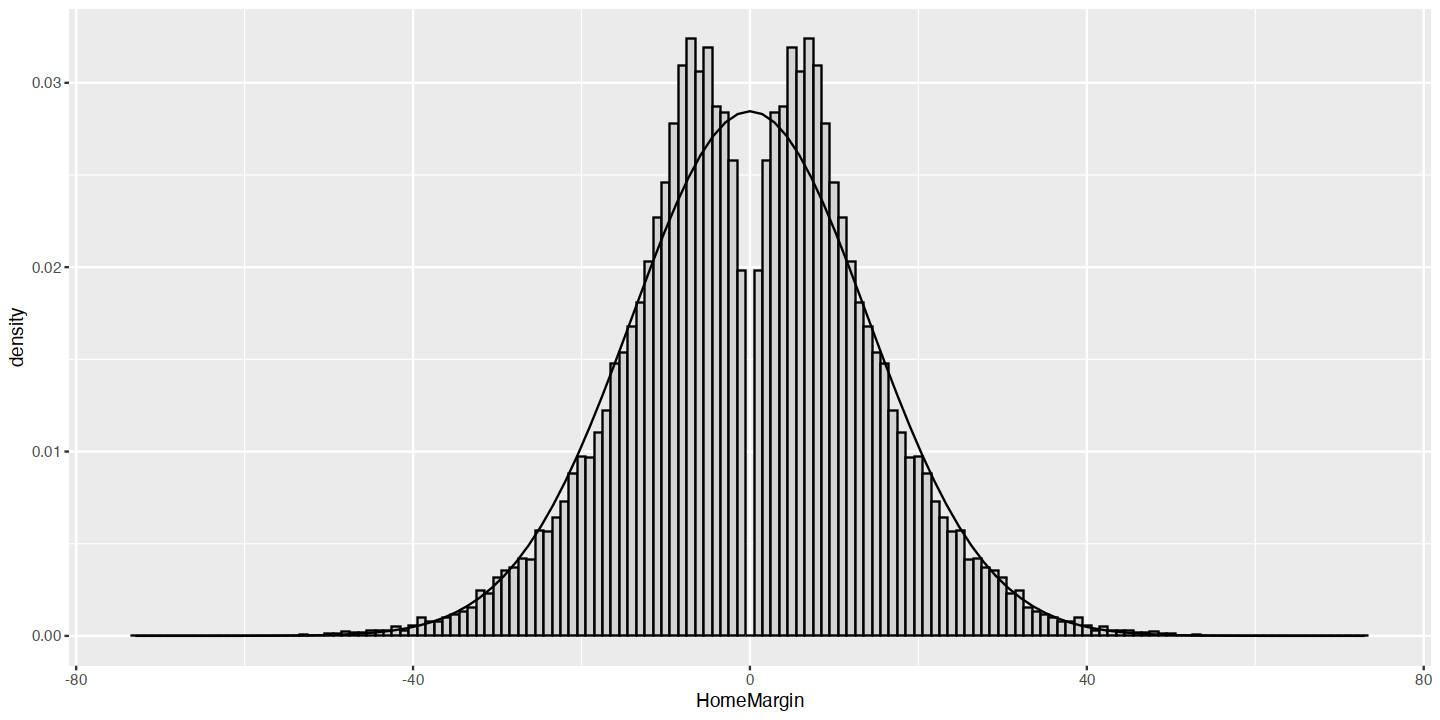

In [20]:
overalldist

So what can we say? The distribution is KIND OF like a normal, with some added parameters to reflect this reality. We can use non-parametric kernel density methods, but to me it is easier to do a simpler MLE approach, where we assume the distribution is roughly normally distributed, but make adjustments for the fact that 0-3pt games are less likely (i.e. allow the ratio of the real distribution relative to what a normal would be to vary, and estimate the ratio that would maximize the likelhood of the actual data). You can see the code for exactly what I do.

Now, there is another variable that is important. Let's say two equal teams are playing. In that case, you would expect the chance of a "close" game to be high and this feature of the distribution to "bite" more and alter the expected distribution. If one team is MUCH better, however, (we expect them to win, say, by 10 points or more) than a close game is less likely, and so the distribution should be a bit closer to normal since it is less likely to fall into the "close game" scenario.

This is exactly what the function ```simulatedist(ExpMargin,ExpPointTotal)``` does. We first predict what we think the "average" margin of victory will be for the home team and the expected total points scored (a high-scoring game will have a wider distribution). Then we use our MLE-estimated coefficients to solve for an "estimated" distribution, and compare it to the "empirical" distribution, which shows the actual distribution for games with an expected margin "near" our ExpMargin parameter.

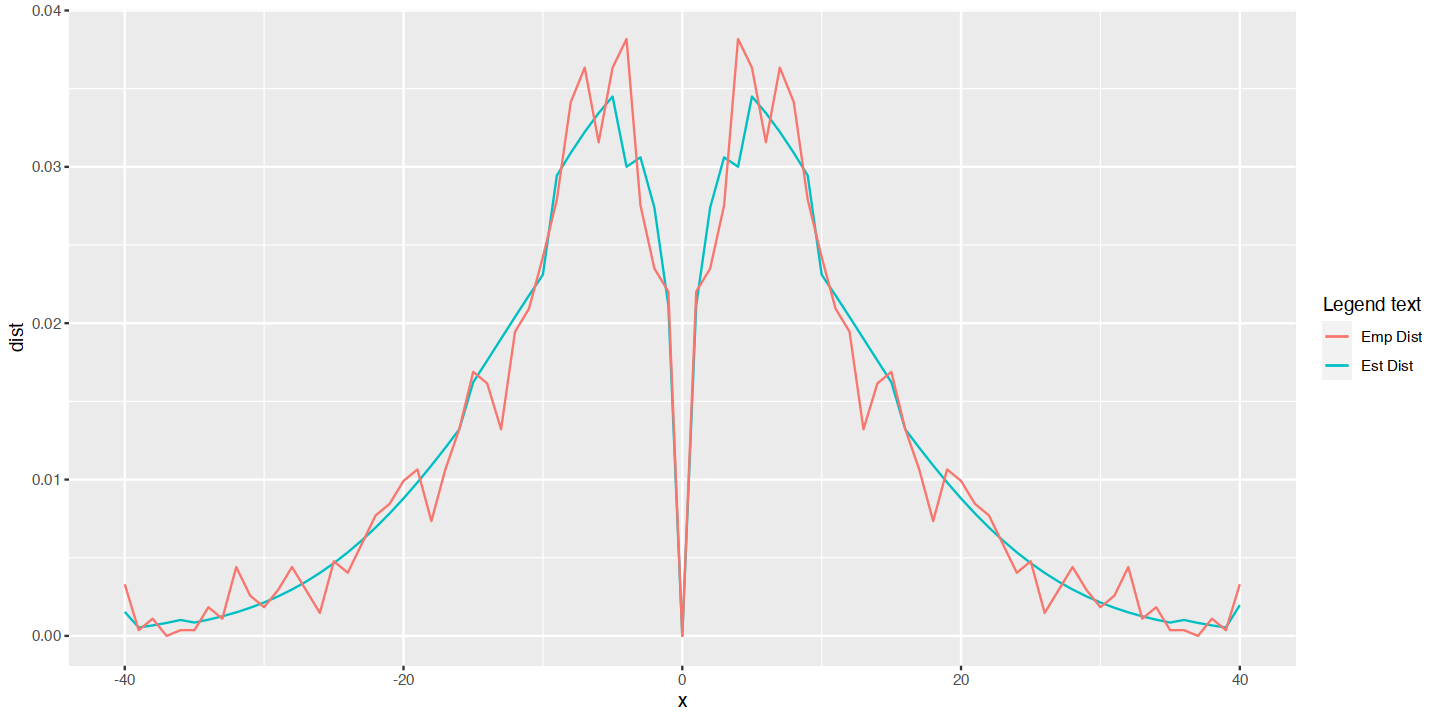

In [21]:
simulatedist(0,225)

You can see if we predict the teams to be equal, the estimated distribution is very similar to the empirical one, but smoothed out (since the empirical distribution is likely noisier than the actual underlying "true" distribution).

The beauty of the model is now we can see what an actual distribution might look like for a team favored by 12 points, which is quite rare. In reality, there are very few games with such a high predicted outcome, so this is where MLE is helpful, since it can impute what the theoretical distribution should be like.

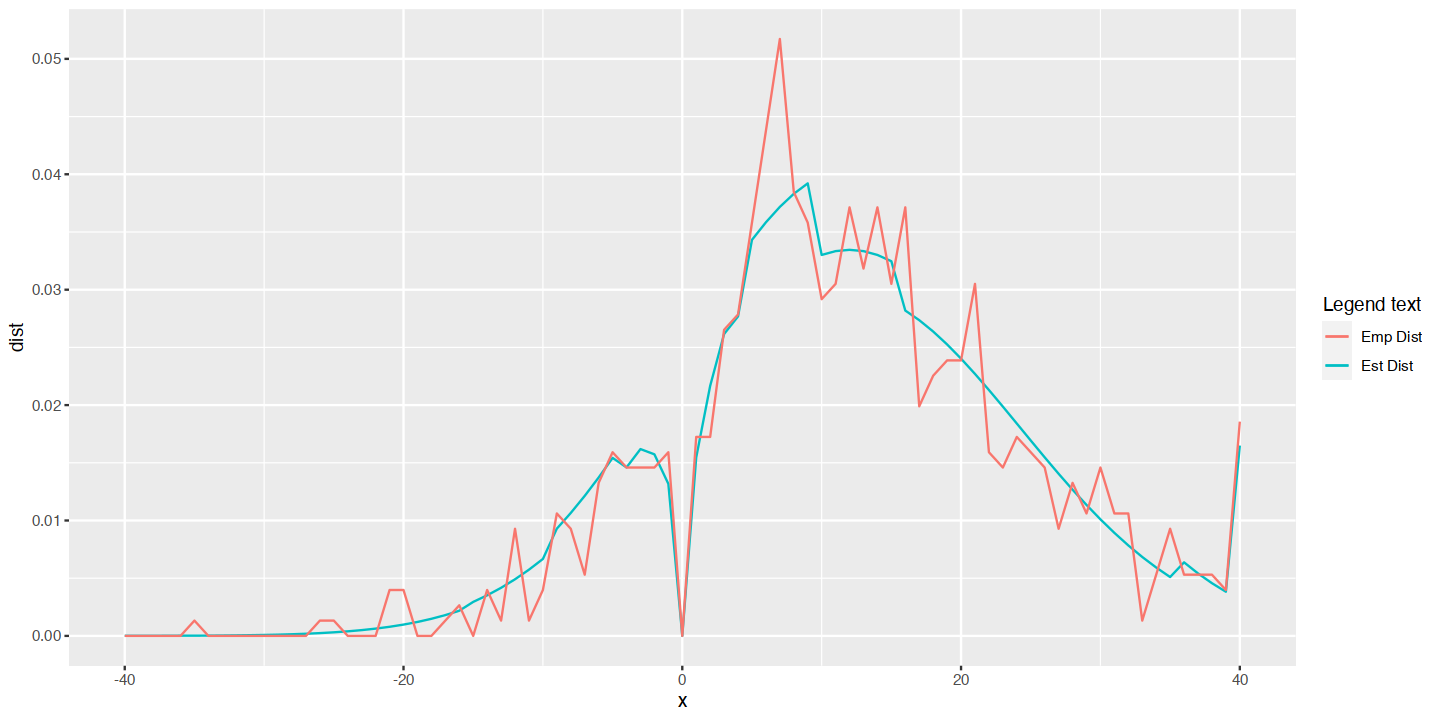

In [22]:
simulatedist(12,225)

Notice how we have smoothed out the empirical distribution quite a bit with just a simple MLE model. So while, ON AVERAGE, we would expect the better team to win by 12pts here (i.e. the average of the distribution), the actual expected distribution of outcomes is not quite normal. Our estimation implies that a "blow out" of 35 or more points is much likelier than a normal distribution would imply, and that a "moderate" win for the better team is much more likeley than a close loss.

Indeed, we can calculate what the expected MEDIAN of this distribution would be, as I do below. Note that the theoretical distribution is assumed to be continuous. In reality we should round the median to the nearest whole number.

In [23]:
simulatemedian(12,225)

[1] 10.07061

And there you have it! The median is actually quite lower than the predicted mean. This is because of that right tail of the distribution, and that large hump in the 5-10 point range.

We can compare the mean and median of a closer game:

In [24]:
simulatemedian(2,225)

[1] 2.628299

So when the predicted mean outcome is 2pts, the median is actually almost a point higher. Why? Well because we know ties and 1- and 2-point games are less likely than we would expect. If the game were to actually play out, the 2-pt favorite would actually be more likely to win by 3pts or 4pts than 2pts. We can see the exact distribution below.

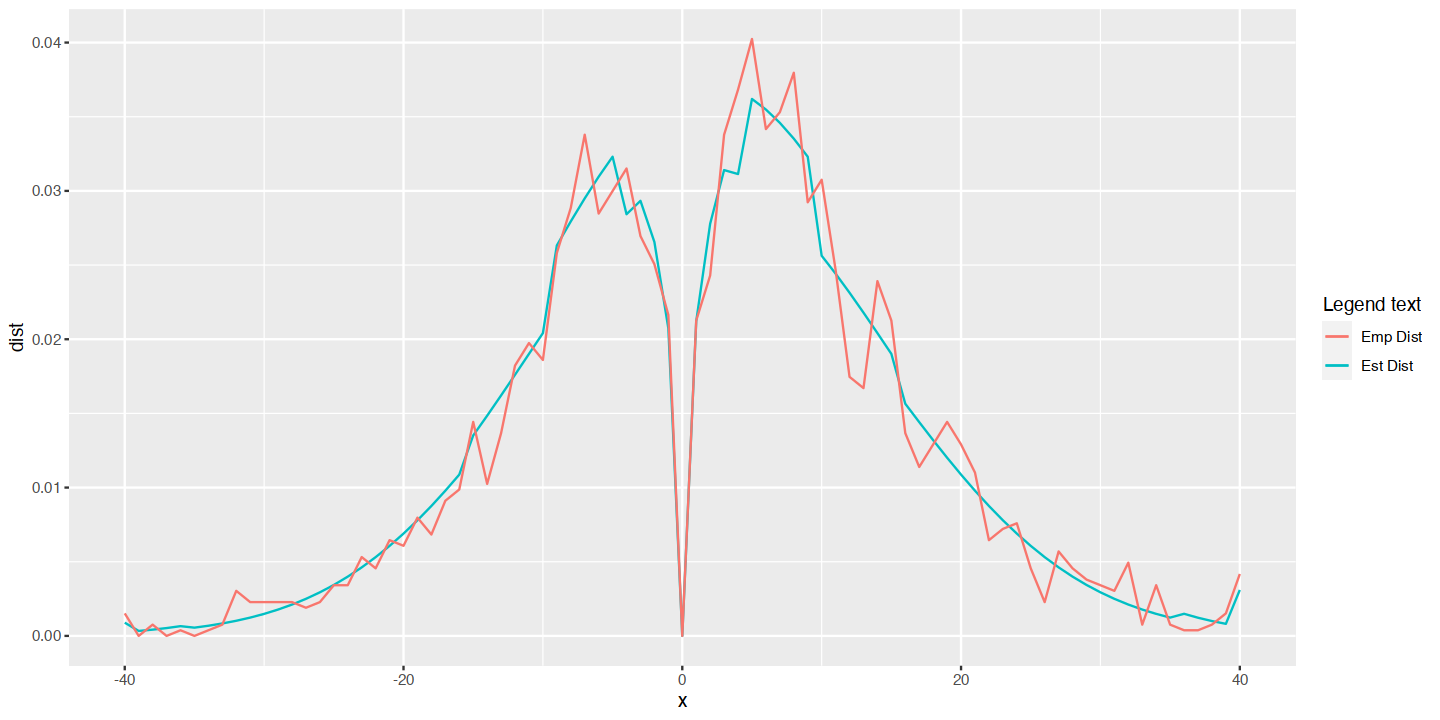

In [25]:
simulatedist(2,225)

## 5. Comparing a Neural Network and Logistic Regression Approach to Predicting Game Outcomes

The idea below is simple. Take two variables: (1) the home team's adjusted net margin for the season and (2) the away team's adjusted net margin to predict the proabbility the home team will win. 

The main variables are the average margin of victory over the season, adjusted for strengths of opponents. This is not as straightforward as you think: early in the season there is no game data (eg Game 1) and for those early games I used an empirical bayes approach to create a best guess for each team's prior performance, and slowly update as the current season gets more data. By Game 20, only the current season's data is used (sort of a smooth updating process).

Then, I manually constructed a neural network with one layer that tries to best classify victories, and compare its performance to a simple logistic regression. ```NBAData_NeuralNet.R``` is quite thorough and well-commented, so hopefully every step is clear: I go through each step of the calculation (as custom functions) from instantiating parameters, to forward propogation, gradient computation, backpropogation to update weights, and iterations until there is some convergence or a certain number of iterations is reach. Then I run code to compare the out-of-sample and in-sample performance of each model.

I run the entire process below. Hopefully the outputs are clear.

In [26]:
#INPUT: folder where git repository lives on your computer
#setwd("/Users/To/GitHub/R/")
suppressWarnings({source("NBAData_NeuralNet.R")}) #gets data from public dropbox link with my data

STEP 1: Training Neur Net Model 

Iteration 100  | loss:  0.6119034  | converge:  3.469236e-06 
Iteration 200  | loss:  0.6117358  | converge:  8.139518e-07 
Iteration 300  | loss:  0.6119278  | converge:  6.290095e-05 
Iteration 400  | loss:  0.6121473  | converge:  4.479591e-06 
Iteration 500  | loss:  0.6122607  | converge:  3.149343e-06 
Iteration 600  | loss:  0.6122397  | converge:  3.270996e-06 
Iteration 700  | loss:  0.6122361  | converge:  2.321495e-06 
Iteration 800  | loss:  0.6122327  | converge:  1.719011e-06 
Iteration 900  | loss:  0.61223  | converge:  1.147474e-06 
Iteration 1000  | loss:  0.6122278  | converge:  6.404382e-07 
Iteration finished at  1000  | loss:  0.6122278  no converge 

STEP 2a: Confusion Matrix for NN (out of sample test) 

      y_predclass
y_test    0    1
     0   65  850
     1   17 1246



STEP 2b: Confusion Matrix for Logistic Reg (out of sample test) 

      logistic_predclass
y_test    0    1
     0  403  512
     1  220 1043


STEP 3: Calc

### Discussion
This shows something I like to call the "kind-of law of small/medium samples". That is, when you have a strong intuition for the data, and what features will be important (in my view, a logistic regression linear in the average net margins is a pretty close approximation), and the sample is not very big (~20,000 rows), then simple regressions tend to perform really well, and more advanced techniques can often have a lot of problems. And, of course, you get the interpretibility/efficiency of linear regression without all the opaqueness of more advanced models.

Of course, it is a matter of execution. In my example, I intentionally created a simple neural network (1 layer with 4 neurons) to show how quickly/easily these sorts of models over-fit the training data. They perform much better in-sample, but much worse out-of-sample. In this case I could literally replicate the logistic regression process in some form in the neural network, but have chosen not to (in other words, just compute the minimized loss funcitons using gradient descent). You have to be very careful about selecting the number of weighting parameters and activation functions used, as well as the loss function (in this case regularization would go a long way).

I could have also implemented a more efficient stochastic gradient descent, but that would simply require random sub-samples of the data rather than estimating it all at once for each iteration, and have chosen not to do so because it would be a trivial addition to the code.

Steps 2 and 3 compare my simple neural network to the logistic regression. The binary cross entropy on the out-of-sample test is much lower for logistic regression (.623 vs .647 for the neural network).

### Takeaways
I have done much more complicated versions of each (many more variables) and the difficulty of using the neural network scales with the number and complexity of the features you choose to include, but, of course, both produce fairly accurate results once you have cross-validated successfully. You should view this as a "proof of concept" that I know what underlies the neural network process. Any more complicated code scales in a similar manner, and of course I usually tend to utilize pre-existing packages in R and Python if the network I am fitting is relatively straightforward.